# Обучение модели YOLO для детектирования ROI

In [2]:
import pandas as pd
import json
import shutil
import os
import matplotlib.pyplot as plt
import cv2

## Загрузка датасета

In [4]:
train_df = pd.read_excel(r'train/train.xlsx')
# Оставляем только класс с наличием патологии, т.к.
# только он содержит annotation
train_df = train_df[train_df['pathology'] == 1]
train_df["id"] = train_df["ID"].apply(
    lambda filename: int(filename.replace("image_", "").split(".")[0])
)
train_df.drop(
    columns=[
        "Unnamed: 0.1",
        "Unnamed: 0",
        "ID",
    ],
    inplace=True,
)
train_df.index = train_df["id"]

print(f'Количество исследований: {len(train_df)}')
train_df.head()

Количество исследований: 262


,image_path,annotation_path_label,pathology,id
id,,,,
393,train/images/image_393.jpg,train/annotation/annotation_393.json,1,393
326,train/images/image_326.jpg,train/annotation/annotation_326.json,1,326
290,train/images/image_290.jpg,train/annotation/annotation_290.json,1,290
206,train/images/image_206.jpg,train/annotation/annotation_206.json,1,206
252,train/images/image_252.jpg,train/annotation/annotation_252.json,1,252


## Визуализация исследования с ROI и центральной точкой

train/images/image_114.jpg


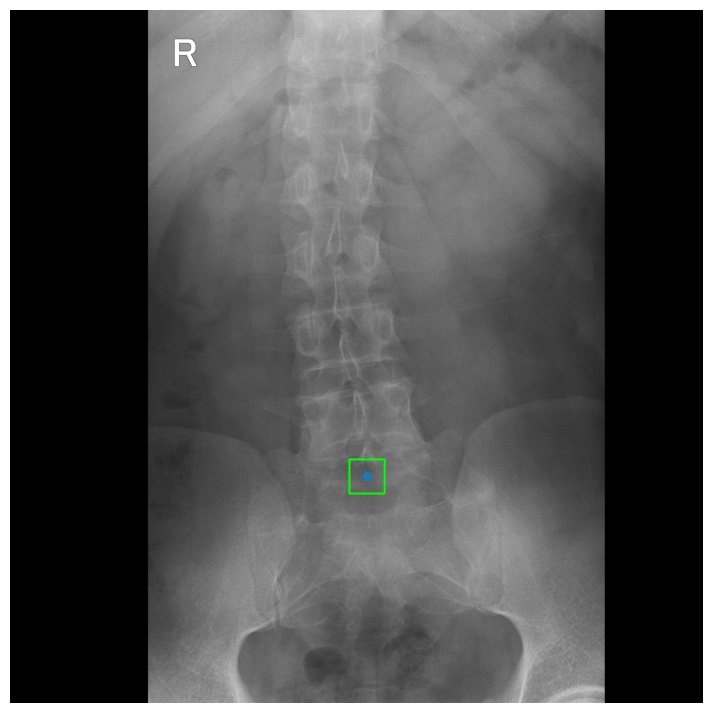

In [5]:
idx = 114

# Загрузка изображения и JSON
image_path = train_df.loc[idx]['image_path']
json_path = train_df.loc[idx]['annotation_path_label']

print(image_path)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Конвертация в RGB для корректного отображения
with open(json_path, 'r') as f:
    data = json.load(f)

# Извлечение координат bbox
bbox = data['annotations'][0]['bbox']
x, y, w, h = map(int, bbox)
x_center = x + (w/2)
y_center = y + (h/2)

# Рисование прямоугольника
cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 6)

# Отображение с помощью matplotlib
plt.figure(figsize=(12, 9))
plt.scatter(x_center, y_center)
plt.imshow(image)
plt.axis('off')
plt.show()

## Формируем YOLO датасет

In [6]:
from pprint import pprint


def create_yolo_coordinate(x_center, y_center, w, h, w_image, h_image):
    """
    Функция для формирования данных о ROI для датасета
    Args:
    x_center: Координаты центральной точки по x
    y_center: Координаты центральной точки по y
    w: Ширина ROI
    h: Высота ROI
    w_image: Ширина изображения
    h_image: Высота изображения

    Return:
    Строка в нужном формате
    """
    x_centerY = x_center / w_image
    y_centerY = y_center / h_image
    wY = w / w_image
    hY = h / h_image
    return f'0 {x_centerY} {y_centerY} {wY} {hY}'

# Получаем список из id исследований
id_list = train_df['id'].to_list()

# Формируем датасет из txt файлов с информацией о ROI
# копируем и переименовываем файлы с изображениями
for idx in id_list:
    image_path = train_df.loc[idx]['image_path']
    json_path = train_df.loc[idx]['annotation_path_label']
    image = cv2.imread(image_path)
    with open(json_path, 'r') as f:
        data = json.load(f)
    bbox = data["annotations"][0]["bbox"]
    x, y, w, h = map(int, bbox)
    x_center = x + (w/2)
    y_center = y + (h/2)
    h_image = image.shape[0]
    w_image = image.shape[1]
    
    # Создаём папки для датасета, если их нет
    if not os.path.isdir("datasets"):
     os.mkdir("datasets")
    if not os.path.isdir("datasets/labels"):
     os.mkdir("datasets/labels")
    if not os.path.isdir("datasets/images"):
     os.mkdir("datasets/images")


    with open(f'datasets/labels/{idx}.txt', 'w') as f:
        f.write(create_yolo_coordinate(x_center, y_center, w, h, w_image, h_image))

    shutil.copy(train_df.loc[idx]['image_path'], os.path.join(f'datasets/images/{idx}.jpg'))
    

## Разбиение датасета на тренирововочную, валидационную и тестовую выборку

In [7]:
import os
import shutil
import random

# Определяем пути к исходным и целевым директориям
source_dir = 'datasets/'
train_dir = 'datasets/train'
val_dir = 'datasets/val'
test_dir = 'datasets/test'

# Создаем целевые директории, если они не существуют
for dir in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(dir, 'labels'), exist_ok=True)

# Получаем список всех файлов изображений
image_files = [f for f in os.listdir(os.path.join(source_dir, 'images')) if f.endswith('.jpg')]

# Перемешиваем список файлов
random.shuffle(image_files)

# Определяем размеры наборов данных
total_files = len(image_files)
train_size = int(0.7 * total_files)
val_size = int(0.15 * total_files)
test_size = total_files - train_size - val_size

# Разделяем файлы на наборы
train_files = image_files[:train_size]
val_files = image_files[train_size:train_size+val_size]
test_files = image_files[train_size+val_size:]

# Функция для копирования файлов
def copy_files(file_list, target_dir):
    for file in file_list:
        image_src = os.path.join(source_dir, 'images', file)
        label_src = os.path.join(source_dir, 'labels', os.path.splitext(file)[0] + '.txt')
        
        image_dst = os.path.join(target_dir, 'images', file)
        label_dst = os.path.join(target_dir, 'labels', os.path.splitext(file)[0] + '.txt')
        
        shutil.copy(image_src, image_dst)
        shutil.copy(label_src, label_dst)

# Копируем файлы в соответствующие директории
copy_files(train_files, train_dir)
copy_files(val_files, val_dir)
copy_files(test_files, test_dir)

print(f"Разделение завершено. Тренировочных файлов: {len(train_files)}, Валидационных: {len(val_files)}, Тестовых: {len(test_files)}")

Разделение завершено. Тренировочных файлов: 183, Валидационных: 39, Тестовых: 40


## Обучение модели на архитектуре YOLO8

In [9]:
from ultralytics import YOLO

model = YOLO("yolov8m.pt")
results = model.train(
    data=f"data.yml",
    batch=0.6, # Больше 0.6 не ставьте пж
    epochs=300,
    imgsz=640,
    patience=30,
    plots=True,
    # degrees=15,
    # mixup=0.5,
)

Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24151MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yml, epochs=200, time=None, patience=30, batch=0.6, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d74c8300dc0>
Traceback (most recent call last):
  File "/home/server/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/home/server/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1441, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


    25856899       158.1         1.005         10.56         10.37        (2, 3, 640, 640)                    list
    25856899       316.3         1.804         15.97         17.29        (4, 3, 640, 640)                    list
    25856899       632.5         3.339         32.23         33.29        (8, 3, 640, 640)                    list
    25856899        1265         6.375         59.39         61.77       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 35 for CUDA:0 14.50G/23.59G (61%) ✅


train: Scanning /home/server/Documents/hack/spina_bifida/datasets/train/labels.cache... 183 images, 0 backgrounds, 0 corrupt: 100%|██████████| 183/183 [00:00<?, ?it/s]
val: Scanning /home/server/Documents/hack/spina_bifida/datasets/val/labels.cache... 39 images, 0 backgrounds, 0 corrupt: 100%|██████████| 39/39 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.000546875), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      13.8G      4.931      13.22      3.103         16        640: 100%|██████████| 6/6 [00:02<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

                   all         39         39          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      13.8G      4.549       11.3      2.925         13        640: 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all         39         39    0.00154      0.179    0.00169   0.000498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200        14G      3.547      7.276      1.969         20        640: 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

                   all         39         39    0.00154      0.179    0.00169   0.000498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200        14G      2.813      3.491      1.649         13        640: 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


                   all         39         39    0.00516      0.179    0.00267   0.000951

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200        14G      2.681      2.297      1.569         12        640: 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

                   all         39         39   0.000884     0.0769   0.000517    0.00016



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200        14G       2.67      2.378      1.535         11        640: 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

                   all         39         39    0.00295      0.179    0.00231   0.000752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200        14G      2.507       2.11      1.442         18        640: 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]

                   all         39         39    0.00295      0.179    0.00231   0.000752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200        14G      2.459      1.874      1.465         18        640: 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

                   all         39         39    0.00295      0.179    0.00231   0.000752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200        14G      2.408      1.917      1.433         16        640: 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all         39         39    0.00295      0.179    0.00231   0.000752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200        14G      2.504      1.866       1.45         15        640: 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


                   all         39         39    0.00295      0.179    0.00231   0.000752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200        14G      2.477      1.711      1.477         14        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

                   all         39         39    0.00295      0.179    0.00231   0.000752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      14.1G      2.441      1.778      1.418         12        640: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

                   all         39         39    0.00295      0.179    0.00231   0.000752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      14.1G      2.344      1.712      1.354         15        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


                   all         39         39    0.00295      0.179    0.00231   0.000752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      14.1G      2.254      1.601      1.329         19        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

                   all         39         39    0.00295      0.179    0.00231   0.000752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      14.1G      2.204      1.564      1.377         14        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]

                   all         39         39    0.00295      0.179    0.00231   0.000752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      14.1G      2.247      1.724      1.396         13        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

                   all         39         39    0.00295      0.179    0.00231   0.000752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      14.2G       2.32      1.719      1.401         17        640: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]

                   all         39         39    0.00295      0.179    0.00231   0.000752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      14.1G      2.279      1.617      1.378         13        640: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


                   all         39         39    0.00295      0.179    0.00231   0.000752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      14.2G      2.216      1.516      1.376         10        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

                   all         39         39    0.00295      0.179    0.00231   0.000752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      14.1G      2.436      1.706      1.436         19        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         39         39    0.00295      0.179    0.00231   0.000752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      14.1G      2.287      1.608      1.401         18        640: 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         39         39    0.00295      0.179    0.00231   0.000752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      14.1G       2.22      1.466      1.411         14        640: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         39         39   0.000463      0.128   0.000257   4.99e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      14.1G      2.052      1.509      1.297         15        640: 100%|██████████| 6/6 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         39         39   0.000135     0.0256   9.41e-05   1.43e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      14.1G      2.228      1.508      1.335         16        640: 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]

                   all         39         39     0.0047     0.0769    0.00451    0.00246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      14.2G      2.122      1.386      1.299         16        640: 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

                   all         39         39      0.264     0.0513     0.0547     0.0173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      14.1G      2.061      1.404      1.354         11        640: 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]

                   all         39         39      0.388      0.205      0.159     0.0611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      14.1G      2.083       1.29      1.259         20        640: 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]

                   all         39         39      0.327      0.333      0.265     0.0901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      14.1G      1.983       1.23      1.281         14        640: 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]

                   all         39         39      0.037      0.333     0.0304    0.00981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      14.1G      2.087      1.319      1.231         15        640: 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

                   all         39         39      0.345      0.359      0.237     0.0865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      14.1G      1.982      1.246      1.211         14        640: 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

                   all         39         39       0.41      0.308      0.282     0.0933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      14.1G      1.882      1.215      1.229          9        640: 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]

                   all         39         39      0.468      0.282      0.287     0.0925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      14.1G       2.06      1.256      1.254         20        640: 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

                   all         39         39      0.331      0.154       0.18     0.0394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      14.1G      2.065      1.238       1.26         15        640: 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]

                   all         39         39      0.239      0.105      0.108     0.0359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      14.1G      2.015        1.2       1.25         15        640: 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

                   all         39         39      0.295      0.282      0.222     0.0726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      14.1G      1.935      1.162      1.292         16        640: 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]

                   all         39         39      0.523      0.308      0.285     0.0954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      14.1G       1.92      1.181      1.233         13        640: 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

                   all         39         39      0.548      0.385      0.395      0.076



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      14.1G      1.898      1.204      1.229         10        640: 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

                   all         39         39      0.491      0.397       0.42      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      14.1G      1.886        1.1      1.204         22        640: 100%|██████████| 6/6 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         39         39      0.529      0.487      0.479       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      14.1G      1.883      1.102      1.185         20        640: 100%|██████████| 6/6 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

                   all         39         39      0.497      0.462       0.39      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      14.1G      1.707      1.013      1.154         10        640: 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]

                   all         39         39      0.412      0.564      0.398      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      14.1G      1.822      1.012      1.165          9        640: 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]

                   all         39         39      0.514      0.154       0.15     0.0692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      14.1G      1.758      1.058      1.141         17        640: 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

                   all         39         39      0.642      0.333      0.339      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      14.1G      1.712     0.9964      1.163         11        640: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]

                   all         39         39      0.445      0.412      0.369      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      14.1G      1.682      1.053      1.149         14        640: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]

                   all         39         39      0.514      0.434        0.4      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      14.1G      1.774      1.046      1.127         12        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]

                   all         39         39       0.55      0.385      0.456      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      14.1G      1.822      1.065       1.17         17        640: 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

                   all         39         39      0.703      0.205      0.215     0.0665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      14.1G      1.564     0.9977      1.112         12        640: 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]

                   all         39         39       0.37      0.333      0.276      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      14.1G      1.616     0.9422        1.1         11        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]

                   all         39         39      0.586       0.59      0.504      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      14.1G      1.666      0.971        1.1         20        640: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

                   all         39         39      0.697      0.359      0.447      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      14.1G      1.604     0.9476      1.086         17        640: 100%|██████████| 6/6 [00:02<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

                   all         39         39      0.632      0.333      0.398      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      14.1G      1.622      1.006      1.112         13        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

                   all         39         39      0.356      0.385      0.333      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      14.1G      1.617     0.9199      1.071         19        640: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

                   all         39         39      0.487      0.487      0.411      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      14.1G      1.552     0.8802      1.113         12        640: 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

                   all         39         39      0.585      0.462      0.445      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      14.1G      1.545     0.8983      1.076         12        640: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]

                   all         39         39      0.549      0.375      0.377        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      14.1G      1.565     0.8972      1.099         18        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

                   all         39         39      0.589      0.295      0.357      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      14.1G       1.47     0.8522      1.054         16        640: 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

                   all         39         39      0.442      0.333      0.319      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      14.1G      1.503      0.878      1.069         15        640: 100%|██████████| 6/6 [00:02<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

                   all         39         39      0.531      0.436      0.379      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      14.1G      1.496     0.8641      1.048         11        640: 100%|██████████| 6/6 [00:02<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]

                   all         39         39      0.607       0.41      0.459      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      14.1G      1.402     0.7871      1.032         14        640: 100%|██████████| 6/6 [00:02<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

                   all         39         39       0.56      0.359      0.369      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      14.1G      1.496     0.8048      1.034         14        640: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

                   all         39         39       0.57      0.462      0.475       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      14.1G      1.451     0.7944      1.031         24        640: 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]

                   all         39         39       0.53      0.462        0.4      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      14.1G      1.505     0.8227      1.043         14        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

                   all         39         39      0.429      0.333      0.407      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      14.1G      1.499     0.8439      1.048         13        640: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]

                   all         39         39      0.644      0.436      0.488      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      14.1G      1.578     0.8323      1.062         14        640: 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]

                   all         39         39      0.592      0.538      0.515      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      14.1G      1.382      0.732      1.018         14        640: 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

                   all         39         39      0.537      0.487      0.474      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      14.1G      1.365     0.7309      1.038          9        640: 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]

                   all         39         39      0.467      0.564      0.439      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      14.1G       1.39     0.7217      1.039         12        640: 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]

                   all         39         39      0.405      0.462      0.385      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      14.1G      1.344     0.7494      1.019         17        640: 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

                   all         39         39      0.413      0.538      0.423      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      14.1G      1.338     0.7045       1.01         18        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

                   all         39         39      0.536      0.462      0.433      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      14.1G      1.328     0.6769     0.9964         13        640: 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]

                   all         39         39      0.603      0.429      0.438      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      14.1G      1.225      0.629     0.9634         24        640: 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

                   all         39         39      0.427      0.487      0.408      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      14.1G      1.297     0.6958      1.002         11        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all         39         39      0.529      0.385      0.367      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      14.1G      1.214     0.6482     0.9599          8        640: 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


                   all         39         39      0.546       0.41       0.36       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      14.1G       1.23      0.663     0.9527         13        640: 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

                   all         39         39      0.527      0.457      0.417      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      14.1G      1.239     0.6367     0.9814         16        640: 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

                   all         39         39      0.491      0.436      0.414      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      14.1G      1.222     0.6616     0.9505         20        640: 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

                   all         39         39      0.505      0.385      0.422      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      14.1G      1.353     0.6596      1.064          8        640: 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

                   all         39         39      0.598      0.459      0.451      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      14.1G      1.393     0.7238      1.004         15        640: 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all         39         39      0.618      0.487       0.47      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      14.1G      1.284     0.6742     0.9829         12        640: 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

                   all         39         39      0.519      0.513      0.412      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      14.1G      1.207     0.6412     0.9751         20        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]

                   all         39         39      0.527      0.436      0.458      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      14.1G      1.307     0.6809       0.96         17        640: 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

                   all         39         39       0.58       0.46      0.429      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      14.1G      1.223      0.629     0.9611         23        640: 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         39         39      0.498      0.487      0.447      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      14.1G      1.226     0.6275     0.9675         13        640: 100%|██████████| 6/6 [00:02<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         39         39      0.613      0.446      0.449       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      14.2G      1.176     0.6046     0.9359         11        640: 100%|██████████| 6/6 [00:02<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]

                   all         39         39      0.592      0.462       0.42      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      14.1G      1.058     0.5554     0.9144         10        640: 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

                   all         39         39      0.638      0.452       0.44      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      14.1G      1.137     0.6231     0.9417         16        640: 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

                   all         39         39      0.518      0.487      0.443      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      14.1G       1.23     0.6385     0.9491         20        640: 100%|██████████| 6/6 [00:02<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all         39         39      0.544      0.513      0.498      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      14.1G      1.179     0.6077     0.9573         12        640: 100%|██████████| 6/6 [00:02<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

                   all         39         39      0.557      0.452      0.474      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      14.1G       1.06     0.5572     0.9256         17        640: 100%|██████████| 6/6 [00:02<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

                   all         39         39      0.538      0.513      0.466      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      14.1G      1.156     0.5939     0.9262         14        640: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]

                   all         39         39      0.559      0.487      0.473      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      14.1G      1.129     0.5716     0.9234         25        640: 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

                   all         39         39      0.503      0.513      0.478      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      14.1G       1.06     0.5797      0.915         12        640: 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

                   all         39         39      0.565      0.436      0.438       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      14.1G       1.06     0.5651     0.9179         18        640: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]

                   all         39         39      0.645      0.462      0.491      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      14.1G      1.084     0.5667     0.9118         18        640: 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

                   all         39         39      0.662      0.462      0.465      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      14.1G      1.077     0.5581     0.9376         11        640: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]

                   all         39         39      0.514      0.489      0.424      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      14.1G        1.1     0.5709     0.9155         19        640: 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]

                   all         39         39      0.566      0.538      0.464      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      14.1G      1.011     0.5246      0.918         12        640: 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

                   all         39         39      0.668      0.538      0.471      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      14.1G      1.062     0.5634     0.9168         18        640: 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]

                   all         39         39       0.58      0.532      0.439      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      14.1G      1.055     0.5318     0.9139         10        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

                   all         39         39      0.468      0.541      0.445      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      14.1G      1.005     0.5508      0.913         14        640: 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]

                   all         39         39      0.557      0.485      0.459      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      14.2G     0.9934     0.5358     0.9141         15        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]

                   all         39         39      0.607      0.538      0.486      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      14.1G      1.071     0.5681     0.9334         12        640: 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]

                   all         39         39      0.546      0.538      0.433      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      14.1G     0.9912     0.5208     0.9045         10        640: 100%|██████████| 6/6 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

                   all         39         39      0.537      0.487      0.428      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      14.1G     0.9725     0.5053     0.9084         18        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]

                   all         39         39      0.578      0.538      0.497        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      14.1G      1.095     0.5502     0.9374         12        640: 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]

                   all         39         39      0.582      0.606      0.584      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      14.1G     0.9773     0.5224     0.8955         16        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]

                   all         39         39      0.568       0.59      0.516      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      14.1G      0.962     0.4983     0.8873         14        640: 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]

                   all         39         39      0.592      0.564       0.49      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      14.1G     0.9288     0.4897     0.8827         23        640: 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]

                   all         39         39       0.57      0.513      0.445      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      14.1G     0.9089     0.4788     0.8896         15        640: 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]

                   all         39         39      0.557      0.484      0.407      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      14.1G     0.9369     0.5002     0.8825         10        640: 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

                   all         39         39      0.538      0.462      0.418      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      14.1G     0.9494     0.4982     0.9033         11        640: 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

                   all         39         39      0.535      0.462      0.432      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      14.1G     0.9131     0.4978     0.8845          8        640: 100%|██████████| 6/6 [00:02<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]

                   all         39         39      0.573       0.41      0.402      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      14.1G     0.9714     0.5092     0.8743         19        640: 100%|██████████| 6/6 [00:02<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

                   all         39         39      0.551      0.487      0.443      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      14.1G     0.9365     0.4847     0.9224         13        640: 100%|██████████| 6/6 [00:02<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

                   all         39         39      0.669      0.385      0.463      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      14.1G     0.9278     0.5156     0.8991         16        640: 100%|██████████| 6/6 [00:02<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

                   all         39         39      0.578      0.526      0.499      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      14.2G     0.9286     0.4997     0.8959         12        640: 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

                   all         39         39      0.534      0.617      0.527      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      14.1G     0.9013      0.482      0.882         10        640: 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]

                   all         39         39      0.579       0.59       0.53      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      14.1G     0.8479     0.4701     0.8738         15        640: 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]

                   all         39         39      0.598      0.534      0.466      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      14.1G     0.9054     0.4651     0.8926         12        640: 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]

                   all         39         39      0.625      0.555      0.515      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      14.1G     0.8741     0.4749     0.8827         14        640: 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

                   all         39         39       0.56      0.588      0.457      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      14.1G     0.8772      0.485     0.8746         10        640: 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]

                   all         39         39      0.567      0.641      0.504      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      14.1G     0.8843     0.4836     0.8827         18        640: 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]

                   all         39         39      0.619      0.513      0.518      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      14.1G     0.8584     0.4516     0.8652         15        640: 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

                   all         39         39      0.553      0.564      0.522      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      14.1G     0.9003     0.4607      0.877         14        640: 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]

                   all         39         39      0.608      0.615      0.547      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      14.1G     0.8389     0.4452     0.8638         16        640: 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


                   all         39         39      0.548      0.538      0.492      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      14.1G     0.9017      0.452      0.895         14        640: 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


                   all         39         39      0.576      0.564      0.501      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      14.1G     0.8881     0.4522     0.8782         12        640: 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]

                   all         39         39      0.565      0.564      0.491      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      14.1G     0.8762     0.4556     0.8905         15        640: 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

                   all         39         39      0.593      0.561       0.49      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      14.1G      0.866     0.4623     0.8689         14        640: 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

                   all         39         39      0.516      0.538      0.445      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      14.1G     0.8439     0.4463     0.8555         17        640: 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]

                   all         39         39       0.55      0.513      0.471      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      14.1G     0.8554     0.4573     0.8474         17        640: 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

                   all         39         39      0.577      0.559       0.49      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      14.1G     0.8542     0.4623     0.8622         11        640: 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


                   all         39         39      0.601       0.59      0.499      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      14.1G     0.7861     0.4298     0.8433         16        640: 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


                   all         39         39      0.642      0.564      0.488        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      14.1G     0.7814     0.4145     0.8466         19        640: 100%|██████████| 6/6 [00:02<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]

                   all         39         39      0.609      0.564      0.474      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      14.1G     0.7601     0.4022     0.8445         11        640: 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]

                   all         39         39      0.626      0.538      0.469      0.185


EarlyStopping: Training stopped early as no improvement observed in last 30 epochs. Best results observed at epoch 105, best model saved as best.pt.
To update EarlyStopping(patience=30) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

135 epochs completed in 0.108 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 52.1MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 52.1MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.2.100 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24151MiB)
Model summary (fused): 218 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


                   all         39         39      0.582      0.606      0.586      0.265
Speed: 0.1ms preprocess, 3.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/train2


## Метрики и визуализация результатов

Просмотреть графики и метрики можно в папке detect/train/

Ниже результаты на валидационной выборке

Text(0.5, 1.0, 'Prediction')

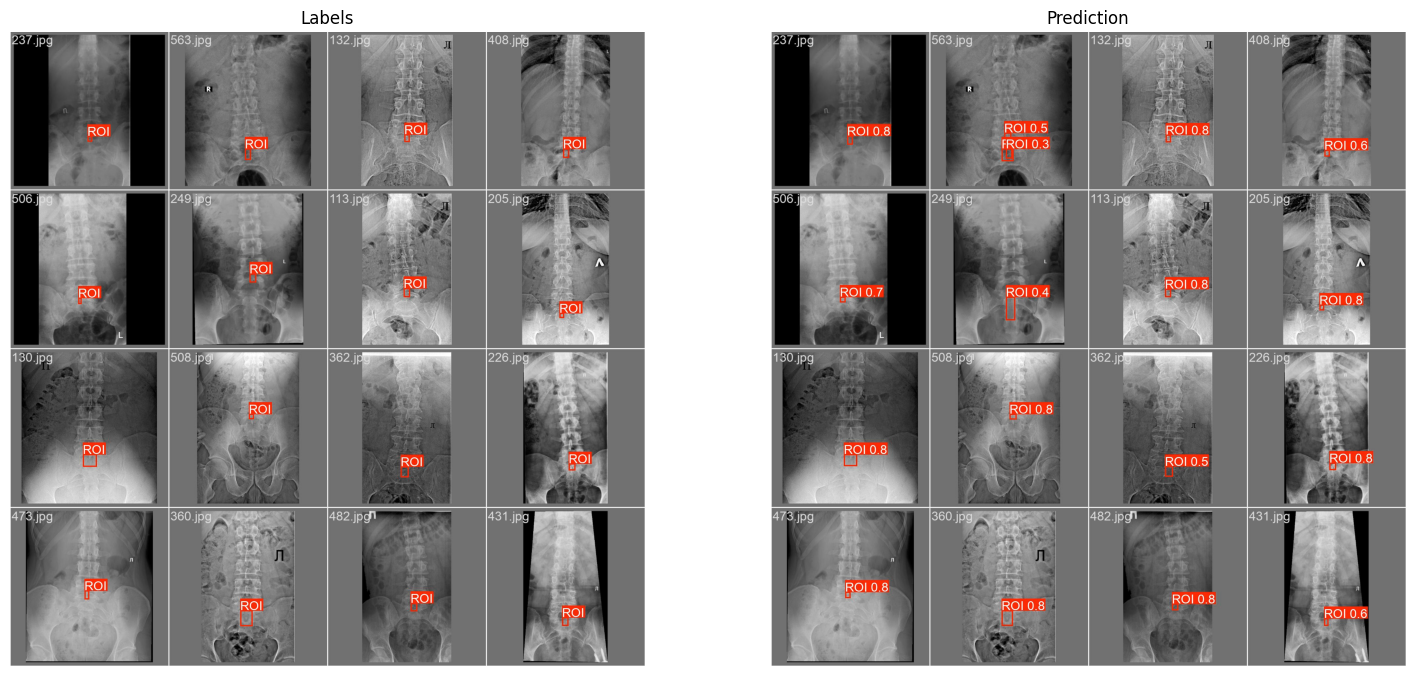

In [19]:
plot1 = cv2.imread(r'detect/train/val_batch0_labels.jpg')
plot2 = cv2.imread(r'detect/train/val_batch0_pred.jpg')

fig = plt.figure(figsize=(18, 9))

fig.add_subplot(1, 2, 1) 
  
plt.imshow(plot1) 
plt.axis('off') 
plt.title("Labels") 
  
fig.add_subplot(1, 2, 2) 

plt.imshow(plot2) 
plt.axis('off') 
plt.title("Prediction") 